# 数据库分库分表

## 什么是分库分表
顾名思义，分库分表就是按照一定的规则，对原有的数据库和表进行拆分，把原本存储于一个库的数据分块存储到多个库上，把原本存储于一个表的数据分块存储到多个表上。

## 分库分表的方式

### 垂直分库/分表

垂直划分数据库是根据业务进行划分，例如将shop库中涉及商品、订单、用户的表分别划分出成一个库，通过降低单库（表）的大小来提高性能，但这种方式并没有解决高数据量带来的性能损耗。同样的，分表的情况就是将一个大表根据业务功能拆分成一个个子表，例如用户表可根据业务分成基本信息表和详细信息表等。

* 优点：
  1. 拆分后业务清晰，达到专库专用。
  2. 可以实现热数据和冷数据的分离，将不经常变化的数据和变动较大的数据分散再不同的库/表中。
  3. 便于维护


* 缺点：
  1. 不解决数据量大带来的性能损耗，读写压力依旧很大
  2. 不同的业务无法跨库关联（join），只能通过业务来关联

### 水平分库/分表

水平划分是根据一定规则，例如时间或id序列值等进行数据的拆分。比如根据年份来拆分不同的数据库。每个数据库结构一致，但是数据得以拆分，从而提升性能。又比如根据用户id的值，根据规则分成若干个表。每个表结构一致,（这点与垂直分库分表相反）。

* 优点：
  1. 单库（表）的数据量得以减少，提高性能
  2. 提高了系统的稳定性和负载能力
  3. 切分出的表结构相同，程序改动较少


* 缺点：
  1. 拆分规则较难抽象
  2. 数据分片在扩容时需要迁移
  3. 维护量增大
  4. 依然存在跨库无法join等问题，同时涉及分布式事务，数据一致性等问题。
  
## 分库分表中Bug解决方案

简而言之，分库分表中若出现事务，`join`，`group by`等操作时通常都是在应用的层面进行优化。

# HashMap

## HashMap简介

* `HashMap`是一个散列表，它存储的内容是键值对(`key-value`)映射。
* `HashMap`继承于`AbstractMap`，实现了`Map`、`Cloneable`、`java.io.Serializable`接口。
* `HashMap`的实现不是同步的，这意味着它不是线程安全的。它的`key`、`value`都可以为`null`。此外，`HashMap`中的映射不是有序的。

```java
public class HashMap<K,V>
    extends AbstractMap<K,V>
    implements Map<K,V>, Cloneable, Serializable { }
```

## HashMap结构

HashMap是通过"拉链法"实现的哈希表。它包括几个重要的成员变量：`table`, `size`, `threshold`, `loadFactor`, `modCount`:

* table是一个`Entry[]`数组类型，而`Entry`实际上就是一个单向链表。哈希表的"`key-value`键值对"都是存储在`Entry`数组中的。

* `size`是`HashMap`的大小，它是`HashMap`保存的键值对的数量。

* `threshold`是`HashMap`的阈值，用于判断是否需要调整`HashMap`的容量。`threshold`的值="容量\*加载因子"，当`HashMap`中存储数据的数量达到`threshold`时，就需要将HashMap的容量加倍。
　　
* `loadFactor`就是加载因子。
　　
* `modCount`是用来实现`fail-fast`机制的。

简单来说，HashMap由数组+链表组成的，数组是HashMap的主体，链表则是主要为了解决哈希冲突而存在的，如果定位到的数组位置不含链表（当前entry的next指向null）,那么对于查找，添加等操作很快，仅需一次寻址即可；如果定位到的数组包含链表，对于添加操作，其时间复杂度为O(n)，首先遍历链表，存在即覆盖，否则新增；对于查找操作来讲，仍需遍历链表，然后通过key对象的equals方法逐一比对查找。所以，性能考虑，HashMap中的链表出现越少，性能才会越好。

> 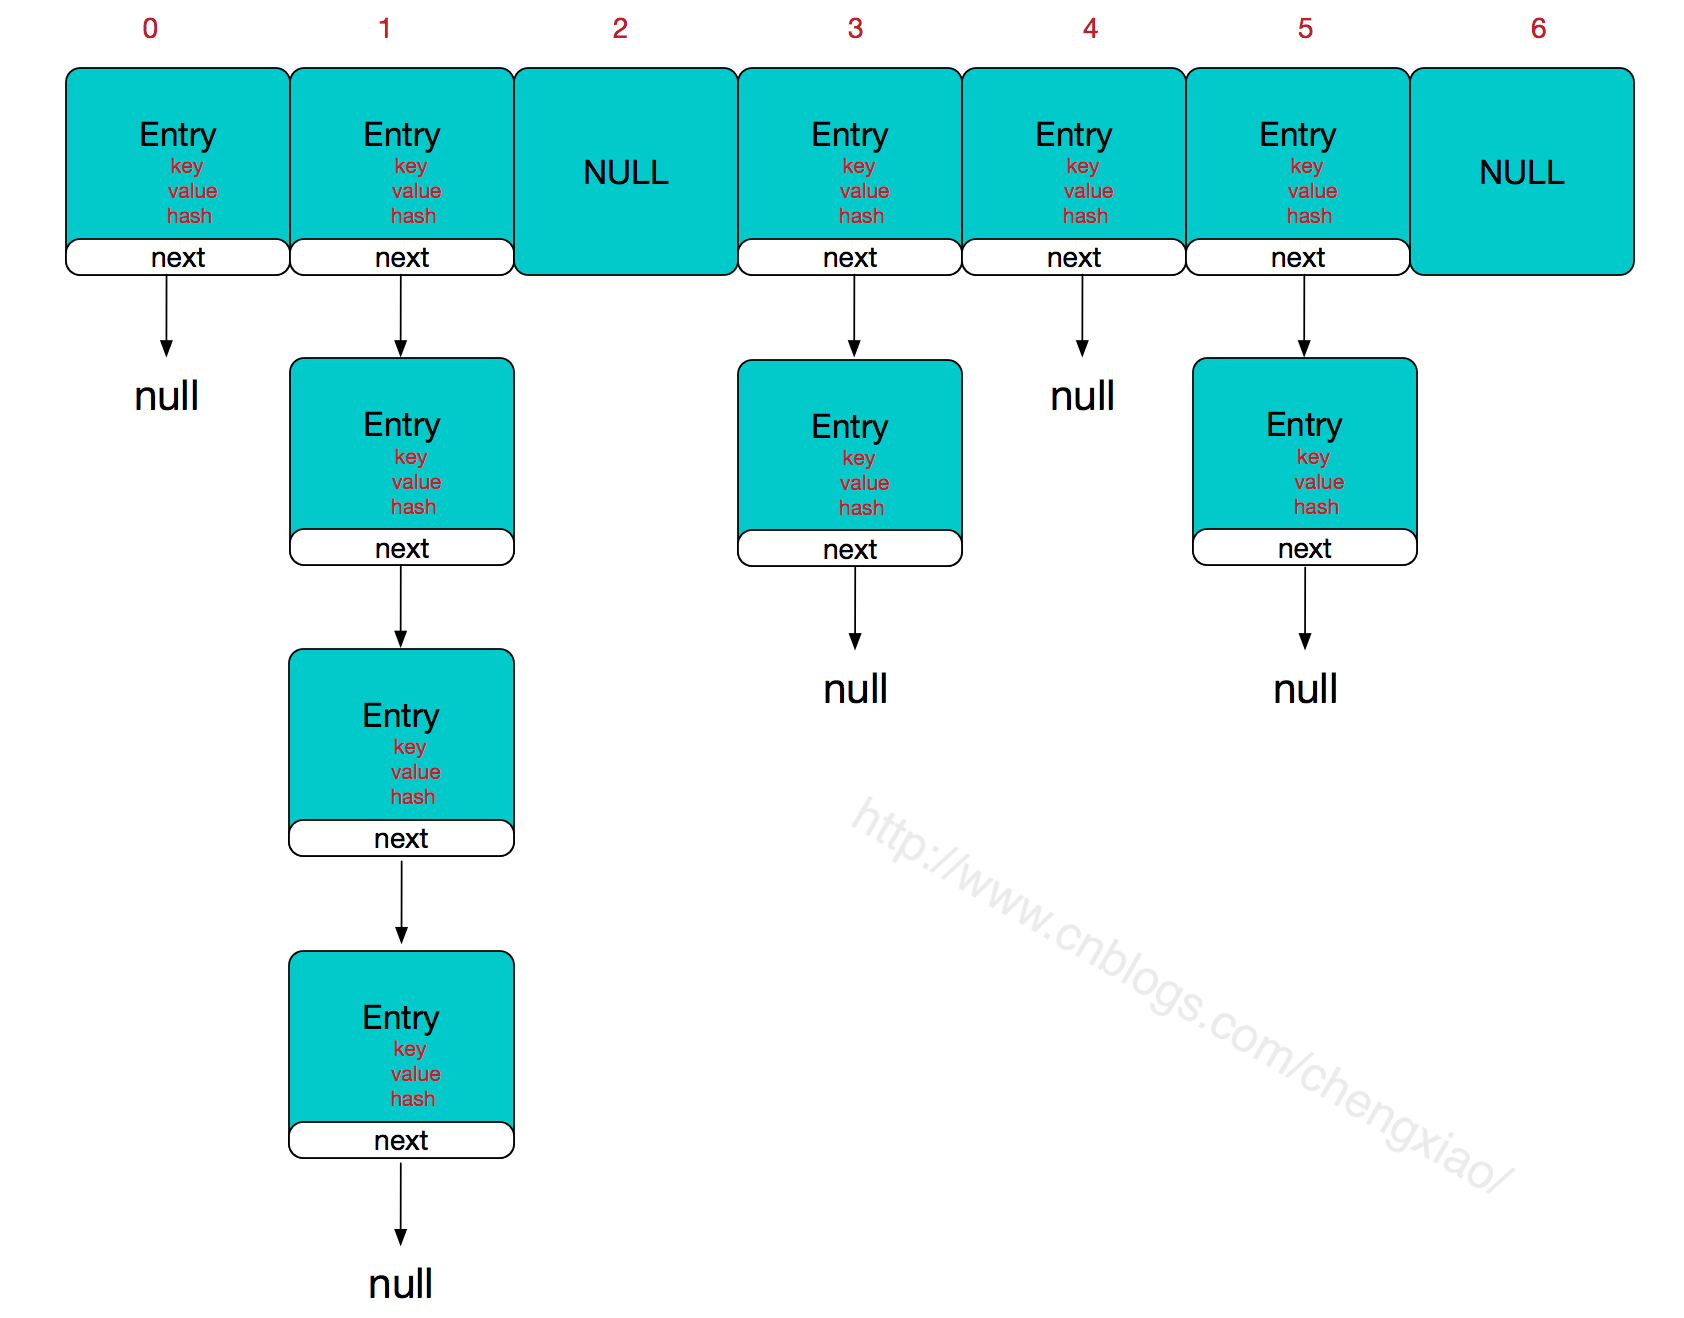

## concurrenthashmap

多线程环境下，使用Hashmap进行put操作会引起死循环，导致CPU利用率接近100%，所以在并发情况下不能使用HashMap。

`HashTable`容器使用`synchronized`来保证线程安全，但在线程竞争激烈的情况下`HashTable`的效率非常低下。因为当一个线程访问`HashTable`的同步方法时，其他线程访问`HashTable`的同步方法时，可能会进入阻塞或轮询状态。如线程1使用put进行添加元素，线程2不但不能使用put方法添加元素，并且也不能使用get方法来获取元素，所以竞争越激烈效率越低。

HashTable容器在竞争激烈的并发环境下表现出效率低下的原因，是因为所有访问HashTable的线程都必须竞争同一把锁，那假如容器里有多把锁，每一把锁用于锁容器其中一部分数据，那么当多线程访问容器里不同数据段的数据时，线程间就不会存在锁竞争，从而可以有效的提高并发访问效率，这就是ConcurrentHashMap所使用的锁分段技术，首先将数据分成一段一段的存储，然后给每一段数据配一把锁，当一个线程占用锁访问其中一个段数据的时候，其他段的数据也能被其他线程访问。

> 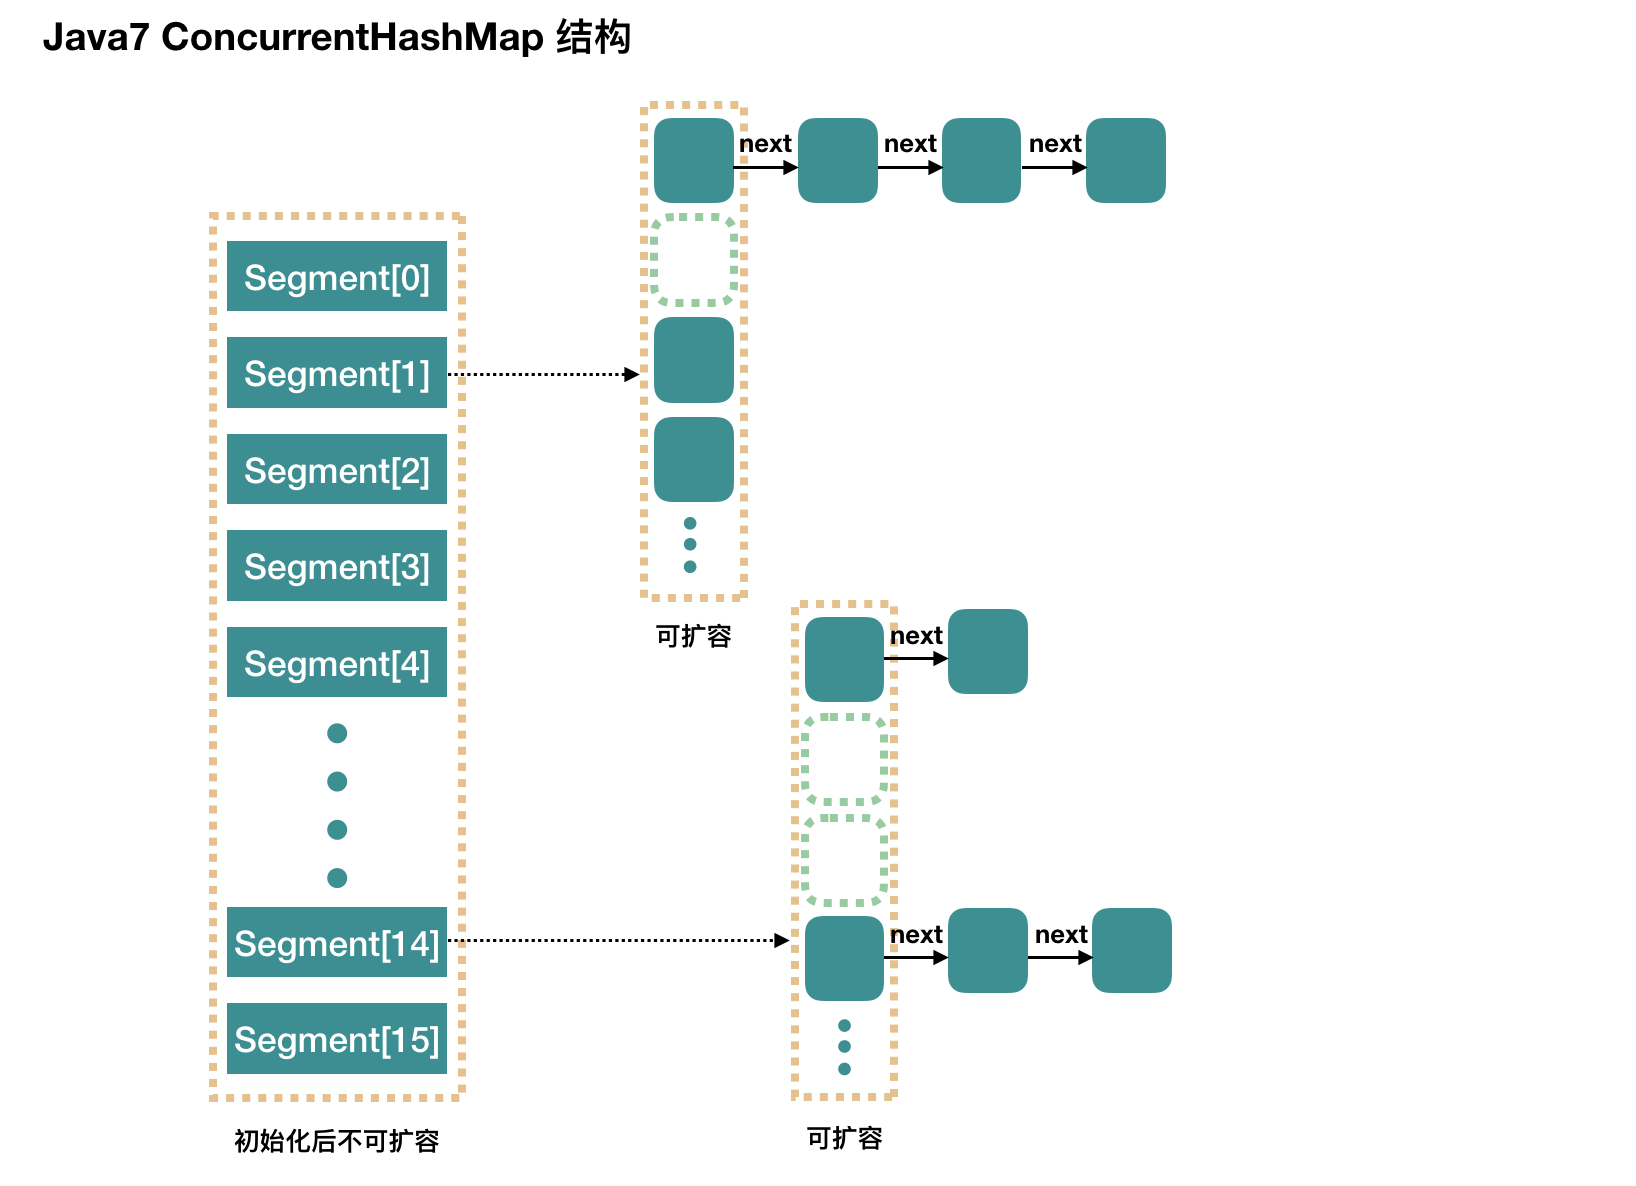

# HashTable

## Hashtable 简介

* 和HashMap一样，Hashtable 也是一个散列表，它存储的内容是键值对(key-value)映射。

* Hashtable 继承于Dictionary，实现了Map、Cloneable、java.io.Serializable接口。

* Hashtable 的函数都是同步的，这意味着它是线程安全的。它的key、value都不可以为null。此外，Hashtable中的映射不是有序的。

## HashMap和Hashtable的区别

HashMap和Hashtable都实现了Map接口，但决定用哪一个之前先要弄清楚它们之间的分别。主要的区别有：线程安全性，同步(synchronization)，以及速度。

1. HashMap几乎可以等价于Hashtable，除了HashMap是非synchronized的，并可以接受null(HashMap可以接受为null的键值(key)和值(value)，而Hashtable则不行)。

2. HashMap是非synchronized，而Hashtable是synchronized，这意味着Hashtable是线程安全的，多个线程可以共享一个Hashtable；而如果没有正确的同步的话，多个线程是不能共享HashMap的。Java 5提供了ConcurrentHashMap，它是HashTable的替代，比HashTable的扩展性更好。
    
3. 另一个区别是HashMap的迭代器(Iterator)是fail-fast迭代器，而Hashtable的enumerator迭代器不是fail-fast的。所以当有其它线程改变了HashMap的结构（增加或者移除元素），将会抛出ConcurrentModificationException，但迭代器本身的remove()方法移除元素则不会抛出ConcurrentModificationException异常。但这并不是一个一定发生的行为，要看JVM。这条同样也是Enumeration和Iterator的区别。
    
4. 由于Hashtable是线程安全的也是synchronized，所以在单线程环境下它比HashMap要慢。如果你不需要同步，只需要单一线程，那么使用HashMap性能要好过Hashtable。
    
5. HashMap不能保证随着时间的推移Map中的元素次序是不变的。

# ThreadLocal

该对象用于在不同线程中进行参数的复制。

首先，在每个线程Thread内部有一个`ThreadLocal.ThreadLocalMap`类型的成员变量`threadLocals`，这个`threadLocals`就是用来存储实际的变量副本的，键值为当前`ThreadLocal`变量，`value`为变量副本（即T类型的变量）。

初始时，在Thread里面，threadLocals为空，当通过ThreadLocal变量调用get()方法或者set()方法，就会对Thread类中的threadLocals进行初始化，并且以当前ThreadLocal变量为键值，以ThreadLocal要保存的副本变量为value，存到threadLocals。

然后在当前线程里面，如果要使用副本变量，就可以通过get方法在threadLocals里面查找。

# volatile关键字

一旦一个共享变量（类的成员变量、类的静态成员变量）被volatile修饰之后，那么就具备了两层语义：

1. 保证了不同线程对这个变量进行操作时的可见性，即一个线程修改了某个变量的值，这新值对其他线程来说是立即可见的。

2. 禁止进行指令重排序。

# 数据库范式

目前关系数据库有六种范式：第一范式（1NF）、第二范式（2NF）、第三范式（3NF）、巴斯-科德范式（BCNF）、第四范式(4NF）和第五范式（5NF，又称完美范式）。

# 数据库隔离级别

* READ UNCIMMITTED（未提交读）

　　事务中的修改，即使没有提交，其他事务也可以看得到，比如说上面的两步这种现象就叫做脏读，这种隔离级别会引起很多问题，如无必要，不要随便使用

　　例子:还是售票系统，小明和小花是售票员，他们分别是两个不同窗口的员工，现在售票系统只剩下3张票，此时A来小华这里买3张票，B来小明买票，小华查到余票还有就给接了订单，就要执行第三步的时候，小明接到B的请求查询有没有余票。看到小华卖出了3张票，于是拒绝卖票。但是小华系统出了问题，第三步执行失败，数据库为保证原子性，数据进行了回滚，也就是说一张票都没卖出去。

　　总结:这就是事务还没提交，而别的事务可以看到他其中修改的数据的后果，也就是脏读。

* READ COMMITTED（提交读）

　　大多数数据库系统的默认隔离级别是READ COMMITTED，这种隔离级别就是一个事务的开始，只能看到已经完成的事务的结果，正在执行的，是无法被其他事务看到的。这种级别会出现读取旧数据的现象

　　例子:还是小明小华销售员，余票3张，A来小华那里请求3张订票单，小华接受订单，要卖出3张票，上面的销售步骤执行中的时候，B也来小明那里买票，由于小华的销售事务执行到一半，小明事务没有看到小华的事务执行，读到的票数是3，准备接受订单的时候，小华的销售事务完成了，此时小明的系统变成显示0张票，小明刚想按下鼠标点击接受订单的手又连忙缩了回去。

　　总结:这就是小华的事务执行到一半，而小明看不到他执行的操作，所以看到的是旧数据，也就是无效的数据

* REPEATABLE READ（可重复读）

 　　REPEATABLE READ解决了脏读的问题，该级别保证了每行的记录的结果是一致的，也就是上面说的读了旧数据的问题，但是却无法解决另一个问题，幻行，顾名思义就是突然蹦出来的行数据。指的就是某个事务在读取某个范围的数据，但是另一个事务又向这个范围的数据去插入数据，导致多次读取的时候，数据的行数不一致。

　　例子:销售部门有规定，如果销售记录低于规定的值，要扣工资，此时经理在后端控制台查看了一下小明的销售记录，发现销售记录达不到规定的次数，心里暗喜，准备打印好销售清单，理直气壮和小明提出，没想到打印出来的时候发现销售清单里面销售数量增多了几条，刚刚好达到要求，气的经理撕了清单纸。原来是小明在就要打印的瞬间卖出了几张票，因此避过了减工资的血光之灾。

　　总结:虽然读取同一条数据可以保证一致性，但是却不能保证没有插入新的数据

 
* SERIALIZABLE（可串行化）

　　SERIALIZABLE是最高的隔离级别，它通过强制事务串行执行（注意是串行），避免了前面的幻读情况，由于他大量加上锁，导致大量的请求超时，因此性能会比较底下，再特别需要数据一致性且并发量不需要那么大的时候才可能考虑这个隔离级别

# 细碎的知识点

* `final`修饰的对象是不可变的吗？（注意区分`final`修饰的容器类对象，对象以及基本数据类型）

* 线程池方面的问题。

* c和c++中`new`操作和`malloc`操作之间的区别。

* python中`dict`实现的细节。

* java中原子变量的知识。

* java1.7之后的各种改变。

* java中`StringBuffer`和`StringBuilder`之间的区别。
  1. `StringBuilder`不是线程安全的。
  2. `StringBuffer`是线程安全的。
  

* 深拷贝和浅拷贝。

* java中Object对象的`hashcode`和`equals`之间的联系。

* c++中的`hashmap`（或者说`unordered_map`）的实现原理。

* servlet是线程安全的吗？
  1. `servlet`是一个单例对象，因此不是线程安全的。每次有网络请求时，tomcat都是为这些请求创建一个线程，然后线程根据请求来获取对应的servlet对象，每个servlet对象都是单例获取的，因此会存在servlet争用的现象。
  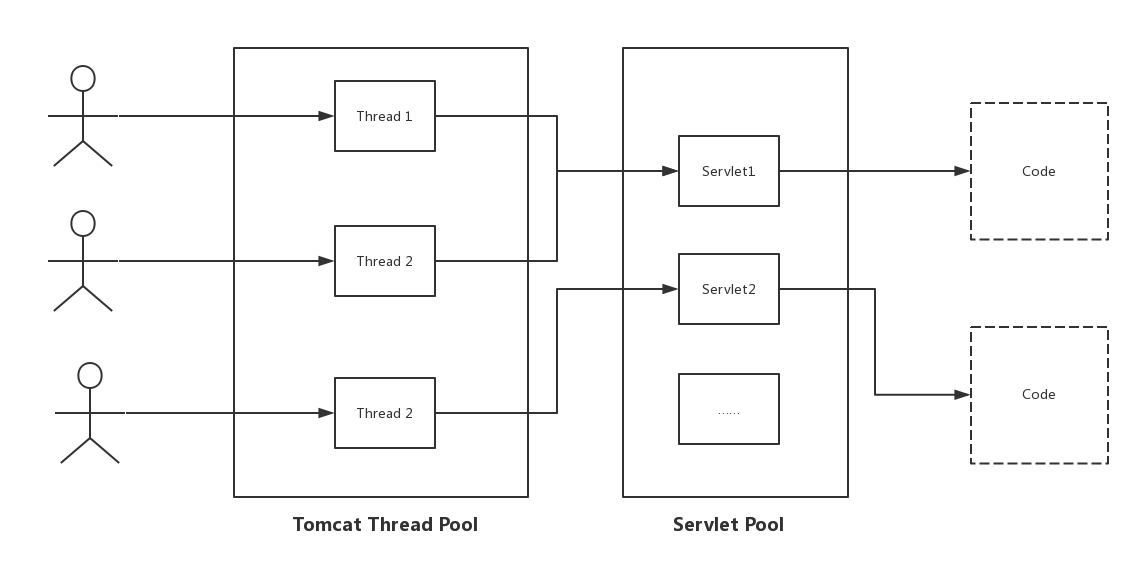

* 线程的状态。
  1. 新建(NEW)：新创建了一个线程对象。

  2. 可运行(RUNNABLE)：线程对象创建后，其他线程(比如main线程）调用了该对象的start()方法。该状态的线程位于可运行线程池中，等待被线程调度选中，获取cpu 的使用权 。

  3. 运行(RUNNING)：可运行状态(runnable)的线程获得了cpu 时间片（timeslice） ，执行程序代码。
  4. 阻塞(BLOCKED)：阻塞状态是指线程因为某种原因放弃了cpu 使用权，也即让出了cpu timeslice，暂时停止运行。直到线程进入可运行(runnable)状态，才有机会再次获得cpu timeslice 转到运行(running)状态。阻塞的情况分三种： 
    1. 等待阻塞：运行(running)的线程执行o.wait()方法，JVM会把该线程放入等待队列(waitting queue)中。
    2. 同步阻塞：运行(running)的线程在获取对象的同步锁时，若该同步锁被别的线程占用，则JVM会把该线程放入锁池(lock pool)中。
    3. 其他阻塞：运行(running)的线程执行Thread.sleep(long ms)或t.join()方法，或者发出了I/O请求时，JVM会把该线程置为阻塞状态。当sleep()状态超时、join()等待线程终止或者超时、或者I/O处理完毕时，线程重新转入可运行(runnable)状态。
  5. 死亡(DEAD)：线程run()、main() 方法执行结束，或者因异常退出了run()方法，则该线程结束生命周期。死亡的线程不可再次复生。

* 虚拟机查看内存状态

* `HashMap`的扩容为什么是2的倍数。

* 红黑树

* 设计模式

* Https的知识点

* `python`中匿名函数的优点（也就是lambda表达式）

* `jre`与`jdk`的概念和联系

* 常见的运行时异常（运行时异常与普通异常的区别与联系）

* 面向对象中多态的理解

* tcp三次握手与四次挥手以及tcp流量控制

* io的多路复用，阻塞io与非阻塞io

* 事件驱动模式